## Startup
Primeiramente são iniciados valores pré-definidos para serem usados como parâmetros.

In [1]:
"""hog"""
orientations = 9
window_dim = [153, 70]
step = [10, 10]
cells_per_block = [6, 3]
pixels_per_cell = [3, 2]
normalize_with = 'L1-sqrt'
visualize = True
desired_confidence = 0.
scale_step = 1.25
sigma = 0.8
canny_sigma = 1


Então define-se as funções de carregar imagens, selecionar imagens aleatoriamente, mostrar imagens, e extrair as features de hog.

In [2]:
import os
from skimage.io import imread
import fnmatch

def load_dir_images(path, fltr):
    img_paths = []
    
    for root, _, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, fltr):
            img_paths.append(os.path.join(root, filename))

    images = []
    for path in img_paths:
        images.append(imread(path))
    return images

In [3]:
import matplotlib.pyplot as plt
import random as rnd
from operator import itemgetter

def select_random_images(images, ceil):
    indx = rnd.sample(range(0, len(images)), ceil)
    imgs = itemgetter(*indx)(images)
    return imgs, indx

def show(images, title = "Random images plot", ceil = 5, is_gray = False):
    im_number = len(images)
    if im_number > ceil:
        imgs = select_random_images(images, ceil)
    elif im_number == 0:
        return
    else:
        imgs = images
    fig, ax = plt.subplots(1, len(imgs), figsize=(23, 2))
    index = 0
    fig.suptitle(title)
    for image in imgs:
        if is_gray:
            ax[index].imshow(image, cmap=plt.cm.gray)
        else:
            ax[index].imshow(image)
        index += 1
    plt.show()

In [4]:
import cv2
import numpy as np

def to_gray(image):
     # If the image is colored, make a grayscale copy
    if image.shape[-1] == 3:
        gray_img = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image
    return gray_img

In [5]:
from skimage.feature import hog, canny
from operator import itemgetter
from skimage.color import rgba2rgb, rgb2gray
import skimage.filters as flt

def extract_features(images, idxs = None):
    fd = []
    imgs = []
    for img in images:
        im = flt.gaussian(img, sigma=(sigma, sigma), truncate=2., multichannel=True)
#         im = to_gray(im)
        if visualize:
            fdi, im = hog(im, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize)
            fd.append(fdi)
            imgs.append(im)
        else:
            fd.append(hog(im, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize))
    if idxs is not None and len(imgs) > max(idxs):
        show(itemgetter(*idxs)(imgs), "hog", is_gray=True)
    return fd

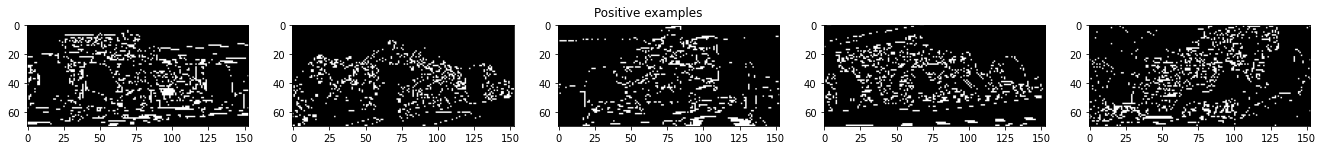

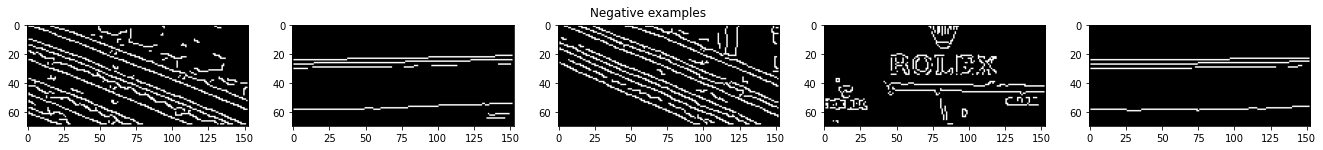

In [6]:
from skimage.transform import resize

pos = load_dir_images("../data/pos/", '*.jpg')
for i in range(0, len(pos)):
    pos[i] = canny(to_gray(pos[i]), sigma=0.75, low_threshold=75, high_threshold=90, use_quantiles=False)
    pos[i] = resize(pos[i], [70, 153])
    #image_filename = "{}.png".format(i)
    #plt.imsave(os.path.join("../data/identified/", image_filename), pos[i], cmap=plt.cm.gray)
pos_sample, pos_idx = select_random_images(pos, 5)
show(pos_sample, "Positive examples", is_gray=True)
neg = load_dir_images("../data/neg/", '*.jpg')
for i in range(0, len(neg)):
    neg[i] = canny(to_gray(neg[i]), sigma=0.75, low_threshold=75, high_threshold=90, use_quantiles=False)
    neg[i] = resize(neg[i], [70, 153])
neg_sample, neg_idx = select_random_images(neg, 5)
show(neg_sample, "Negative examples", is_gray=True)

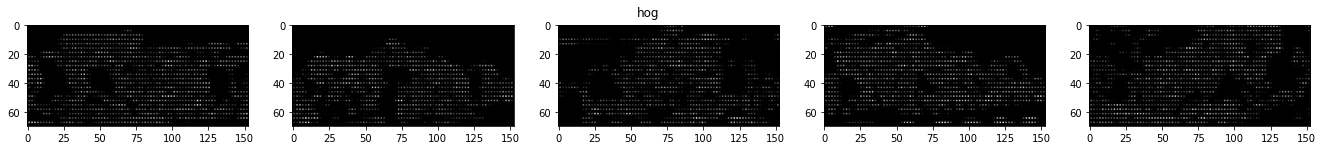

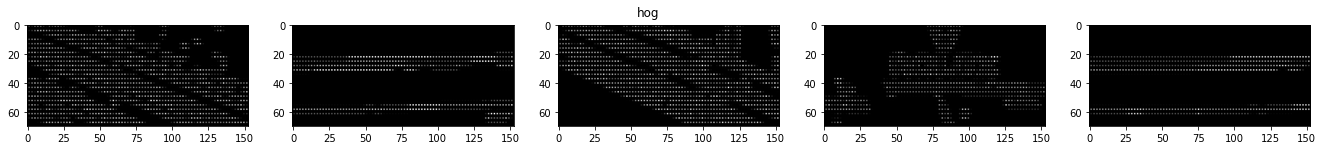

In [7]:
pos_fd = extract_features(pos, pos_idx)
neg_fd = extract_features(neg, neg_idx)

In [8]:
from sklearn.svm import LinearSVC

def train_svm(pos_fd, neg_fd):
    target = []
    features = []
    for fd in pos_fd:
        target.append(1)
        features.append(fd)

    for fd in neg_fd:
        target.append(0)
        features.append(fd)

    machine = LinearSVC(max_iter=10000, tol=1e-5, verbose=1)
    machine.fit(features, target)
    return machine

In [9]:
from collections import namedtuple
Window = namedtuple("Window", "x y pixels is_border is_bottom")

def get_next_point(current, shape):
    x = current.x + step[0]
    bottom = current.is_bottom
    border = False
    if x >= shape[1] or current.is_border:
        x = 0
        y = current.y + step[1]
    elif x + window_dim[0] > shape[1]:
        x = shape[1] - window_dim[0]
        y = current.y
        border = True
    else:
        y = current.y

    if y >= shape[0] or (current.is_bottom and current.is_border):
        raise type("ImageBoundsReached", (Exception, object), {})
    elif y + window_dim[1] > shape[0]:
        y = shape[0] - window_dim[1]
        bottom = True
    return x, y, border, bottom    

In [10]:
def get_next_window(image, current=None):
    if current is None:
        x, y = 0, 0
        bottom = False
        border = False
    else:
        try:
            x, y, border, bottom = get_next_point(current, image.shape)
        except Exception:
            return None
        #x, y = current.x + step[0], current.y + step[1]
    return Window(x, y, image[y:y+window_dim[1], x:x+window_dim[0]], border, bottom)

In [11]:
def widen_search(original, scale, previous):
    if scale <= 0:
        return original
    if previous is not None: 
        if previous.shape[1] == window_dim[1] or previous.shape[0] == window_dim[0]:
            return None
    new_width = original.shape[0]//scale
    if new_width < window_dim[0]:
        scale = original.shape[0]/window_dim[0]
        new_height = original.shape[1]//scale
        return resize(original, [window_dim[0], new_height]) 
    new_height = original.shape[1]//scale
    if new_height < window_dim[1]:
        scale = original.shape[1]/window_dim[1]
        new_width = original.shape[0]//scale
        return resize(original, [new_width, window_dim[1]]) 
    return resize(original, [new_width, new_height])


[LibLinear]

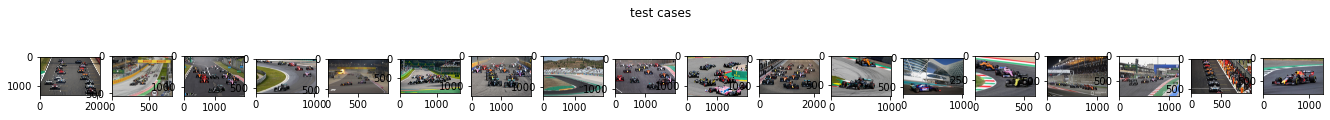

interactive(children=(Dropdown(description='source', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

In [12]:
import numpy as np
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


test = load_dir_images("../data/test/", '*.jpg')

def valor(source):
    classify_svm(machine, test[source], 0, False)

def classify_svm(machine, image, count, verbose=False):
    im = None
    img = None
    scale = scale_step
    maximum = 0
    turn = 0
    fitting_im = to_gray(image)
    fitting_im = canny(fitting_im, sigma=0.75, low_threshold=75, high_threshold=90, use_quantiles=False)
    while((img := widen_search(fitting_im, scale**turn, img)) is not None):
        img = flt.gaussian(img, sigma=(sigma, sigma), truncate=2., multichannel=True)
        print(img.shape)
        while((im := get_next_window(img, im)) is not None):
            if verbose:
                print("Running with window at ({}, {}) up to ({},{})".format(im.x,
                                                                         im.y,
                                                                         im.pixels.shape[1]+im.x,
                                                                         im.pixels.shape[0]+im.y))
            if visualize and verbose:
                result = hog(im.pixels, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize)
                feat, im_hog = result
                show([im_hog, im.pixels], "hog", 2, True)
            else:
                feat = hog(im.pixels, orientations, pixels_per_cell, cells_per_block, normalize_with, visualize and verbose)
            feat = np.array(feat).reshape(1, (len(feat)))
            prediction = machine.predict(feat)
            confidence = machine.decision_function(feat)
            maximum = confidence if maximum < confidence else maximum
            if prediction == 1 and confidence >= desired_confidence:
                if verbose:
                    print("Found one at ({},{}) up to ({},{})".format(im.x,
                                                                      im.y,
                                                                      im.pixels.shape[1]+im.x,
                                                                      im.pixels.shape[0]+im.y))
                image_filename_2 = "{}_or.png".format(confidence)
                in_y = im.y
                in_x = im.x
                scl = scale**turn
                plt.imsave(os.path.join("../data/identified/", image_filename_2), 
                               image[int(in_y*scl):int((in_y+im.pixels.shape[0])*scl),
                                     int(in_x*scl):int((in_x+im.pixels.shape[1])*scl)],
                               cmap=plt.cm.gray)
                #show([im_hog, im.pixels], "hog", 2, True)
                #plt.show()
                image_filename = "{}.png".format(confidence)
                plt.imsave(os.path.join("../data/identified/", image_filename), im.pixels)
            
        turn += 1

sources = [i for i in range(0, len(test))]
test_cases = len(test)
machine = train_svm(pos_fd, neg_fd)
selected_test_case = rnd.randint(0, test_cases)
#print("Of {} possible, test case #{} was selected.".format(test_cases, selected_test_case))
#selected_test_case = test[selected_test_case]
#plt.imshow(selected_test_case)
#plt.show()
show(test, "test cases", len(test))
val = interact_manual(valor, source=sources)